# TP 3 - Image reconstruction in X-ray tomography

In [87]:
import time
import pickle
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [88]:
def plot_true_and_reconstructed(true, reconstructed, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(true)
    axes[0].set_title('True')
    axes[1].imshow(reconstructed)
    axes[1].set_title('Reconstructed')
    diff = axes[2].imshow(np.abs(true - reconstructed))
    axes[2].set_title(fr'Difference ($\|x - \bar x\|=$ {np.linalg.norm(true - reconstructed):.3f})')
    fig.suptitle(title)
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(diff, cax=cax, orientation='vertical')
    plt.show()

## 1 - X-ray tomography

### Question 1.

In [89]:
H: np.ndarray = loadmat("data/H.mat")["H"]
x: np.ndarray = loadmat("data/x.mat")["x"]
M, N = H.shape[0], H.shape[1]
x = x.reshape((N))

### Question 2.

In [90]:
sigma = 1
y = H @ x + np.random.normal(0, sigma, size=(M))

### Question 3.

In [91]:
N0 = 90
N1 = 90
M0 = 90
M1 = 180

assert N0 * N1 == N
assert M0 * M1 == M

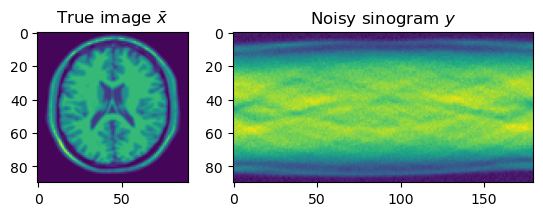

In [92]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})
true_image = x.reshape((N0, N1), order="F")
axes[0].imshow(true_image)
axes[0].set_title(r"True image $\bar{x}$")
axes[1].imshow(y.reshape((M0, M1), order="F"))
axes[1].set_title(r"Noisy sinogram $y$")
plt.show()

## 2 - Optimization problem

### Question 1.

In [93]:
G = loadmat("data/G.mat")["G"]
assert G.shape == (2 * N, N)
lambd = 0.13
delta = 0.02

In [94]:
# This will be useful for later, notably part 3.6
class Algorithm:
    def __init__(self, name, f, df, lambd=lambd, delta=delta, verbose=True):
        self.name = name
        self.f = f
        self.df = df
        self.lambd = lambd
        self.delta = delta
        self.f_values = []
        self.cv_time = None
        self.reconstruction = None
        self.iteration = None
        self.verbose = verbose

    def step(self):
        pass

    def is_converged(self, x):
        return np.linalg.norm(self.df(x)) < np.sqrt(N) * 1e-4

    def plot_f_over_iterations(self, ax=None):
        with sns.axes_style("darkgrid"):
            if ax is not None:
                ax.plot(self.f_values)
                ax.set_xlabel("Iteration")
                ax.set_ylabel("f(x)")
                ax.set_yscale("log")
                ax.set_title(f"{self.name} - {self.cv_time:.3f}s")
            else:
                plt.plot(self.f_values)
                plt.xlabel("Iteration")
                plt.ylabel("f(x)")
                plt.yscale("log")
                plt.title(f"f(x) over iterations for {self.name} - {self.cv_time:.3f}s")
                plt.show()

    def run(self, x0):
        t0 = time.time()
        x = x0
        self.f_values = [self.f(x0)]
        self.iteration = 0

        while not self.is_converged(x):
            x_new = self.step(x)
            x = x_new
            self.f_values.append(self.f(x))
            self.iteration += 1
        self.cv_time = time.time() - t0
        if self.verbose:
            print(f"Converged after {self.iteration} iterations in {self.cv_time:.3f} seconds.")
        self.reconstruction = x


def save_run(algo: Algorithm, filename):
    # To save a run to avoid relaunching it if needed
    with open(f"runs/{filename}.pkl", "wb") as f:
        run =  {
            "name": algo.name,
            "lambd": algo.lambd,
            "delta": algo.delta,
            "f_values": algo.f_values,
            "cv_time": algo.cv_time,
            "reconstruction": algo.reconstruction,
            "iteration": algo.iteration
        
        }
        pickle.dump(run, f)
        
def load_run(Algo, filename, f, df):
    # To load a saved run, applying default parameters for initialization of algorithm-specific parameters 
    with open(f"runs/{filename}.pkl", "rb") as f:
        run = pickle.load(f)
        name = run["name"]
        lambd = run["lambd"]
        delta = run["delta"]
        f_values = run["f_values"]
        cv_time = run["cv_time"]
        reconstruction = run["reconstruction"]
        iteration = run["iteration"]
    algo = Algo(name, f=f, df=df, lambd=lambd, delta=delta)
    algo.f_values = f_values
    algo.cv_time = cv_time
    algo.reconstruction = reconstruction
    algo.iteration = iteration
    return algo

### Question 2.

We have :
\begin{align*}
    \nabla f(x) & = H^T(Hx-y)+\lambda \nabla r(x)
\end{align*}
The gradient of $r$ is a bit more challenging. First let's remark that $\forall n \in \llbracket 1, 2N \rrbracket, \forall i \in \llbracket 1, N \rrbracket, \ \frac{\partial [Gx]^{(n)}}{\partial x^{(i)}}=G^{(n,i)}$. We also have :
\begin{align*}
    \frac{\partial \psi(u(z))}{\partial z} & = \frac{2\frac{\partial u}{\partial z}(z)u(z)/\delta^2}{2\sqrt{1+u(z)^2/\delta^2}} \\
                                           & =\frac{\partial u}{\partial z}(z)\frac{u(z)}{\delta\sqrt{\delta^2+u(z)^2}}
\end{align*}
Taking those two results together, we get :
$$\boxed{\nabla f(x)=H^T(Hx-y)+\lambda \sum_{n=1}^{2N}\frac{[Gx]^{(n)}}{\delta\sqrt{\delta^2+\left([Gx]^{(n)}\right)^2}}\begin{pmatrix}G^{(n,1)} \\
        \vdots    \\
        G^{(n,i)} \\
        \vdots
        \\G^{(n,N)}\end{pmatrix} = H^T(Hx-y)+\lambda G^T \dot{\psi}(Gx)}$$
with $\dot \psi$ the derivative of $\psi$.

In [95]:
psi = lambda x: np.sqrt(1 + (x/delta)**2)

r = lambda x: np.sum(psi(G @ x))

f = lambda x: 1/2 * np.linalg.norm(H @ x - y)**2 + lambd * r(x)

def grad_f(x):
    prod = G @ x
    g = prod / delta / np.sqrt(delta**2 + prod**2)
    df = H.T @ (H @ x - y) + lambd * G.T @ g
    return df

### Question 3.

Let $x,z\in\mathbb{R}^N$ and let us show that $\nabla f$ is $L$-Lipschitz with $L=\lambda/\delta^2\|G\|^2+\|H\|^2$. We have :
\begin{align*}
    \|\nabla f(x)-\nabla f(z)\|_2 & \leq \|H^TH(x-z)\|_2+\lambda \left \|\sum_{n=1}^{2N}\dots\right \|_2 \\
                                  & \leq \|H^TH\|\cdot\|x-z\|_2 + \lambda \|\dots\|_2                    \\
                                  & \leq \|H\|^2\cdot\|x-z\|_2 + \lambda \|\dots\|_2
\end{align*}

using Cauchy-Schwarz and properties of the spectral norm. When we do not write what norm we are using we are assuming the cannonical norm on linear applications : $\|A\|_{\mathcal{L}(V,W)}=\sup_{u\in V\setminus \left\{0\right\}}\frac{\|Au\|_W}{\|u\|_V}$. Let's focus on the second term. Consider $h:\begin{cases}
        \mathbb{R}\to\mathbb{R} \\x\mapsto \frac{x}{\delta\sqrt{\delta^2+x^2}}
    \end{cases}$. We have $h'(x)=\frac{\delta}{(\delta^2+x^2)^{3/2}}$. This derivative is bounded by $1/\delta^2$ on $\mathbb{R}$, so $h$ is $1/\delta^2$-Lipschitz. We denote $g(x)$ the vector such that $\forall n\in \left\{1,\dots,2N\right\}, g(x)^{(n)}=\frac{[Gx]^{(n)}}{\delta\sqrt{\delta^2+[Gx]^{(n)2}}}=h([Gx]^{(n)})$. We can rewrite the right part of the gradient of $f$ as $\lambda G^Tg(x)$ (we made the sum disappear which is good because the triangular inequality led to a looser bound with the Frobenius norm). We have :
\begin{align*}
    \|G^Tg(x)-G^Tg(z)\|_2 & = \|G^T(g(x)-g(z))\|_2                                                                                                                               \\
                          & \leq \|G^T\|_{\mathcal{L}(\mathbb{R}^N,\mathbb{R}^{2N})}\|g(x)-g(z)\|_2                                                                              \\
                          & \leq \|G\|_{\mathcal{L}(\mathbb{R}^{2N},\mathbb{R}^N)}\frac{1}{\delta^2}\|Gx-Gz\|_2 & \text{using that } h \text{ is } 1/\delta^2 \text{ Lipschitz}. \\
                          & \leq \frac{1}{\delta^2}\|G\|^2\|x-z\|_2
\end{align*}
In total the Lipschitz constant of $\nabla f$ is :
$$\boxed{L = \|H\|^2+\lambda/\delta^2 \|G\|^2}$$

In [96]:
def spectral_norm(A: sps.csr_matrix):
    return sps.linalg.svds(A, k=1, which="LM", return_singular_vectors=False)[0]


L = spectral_norm(H.T @ H) + lambd * spectral_norm(G.T @ G) / delta**2

print("Lipschitz constant: ", L)

Lipschitz constant:  18092.7732768648


## 3 - Optimization algorithms

### 3.1 - Gradient descent algorithm

#### Question 1.

In [97]:
x0 = np.zeros(N)

#### Question 2.

In [98]:
class GradientDescent(Algorithm):
    def __init__(self, name, f, df, lr=1.9/L, lambd=lambd, delta=delta, verbose=True):
        super().__init__(name, f, df, lambd, delta, verbose)
        self.lr = lr

    def step(self, x) -> np.ndarray:
        """lr should be taken strictly smaller than 2/L, where L is the Lipschitz constant of df."""
        grad = self.df(x)
        return x - self.lr * grad

gd = GradientDescent("gradient descent", f, grad_f, 1.9 / L)

Converged after 2317 iterations in 70.380 seconds.


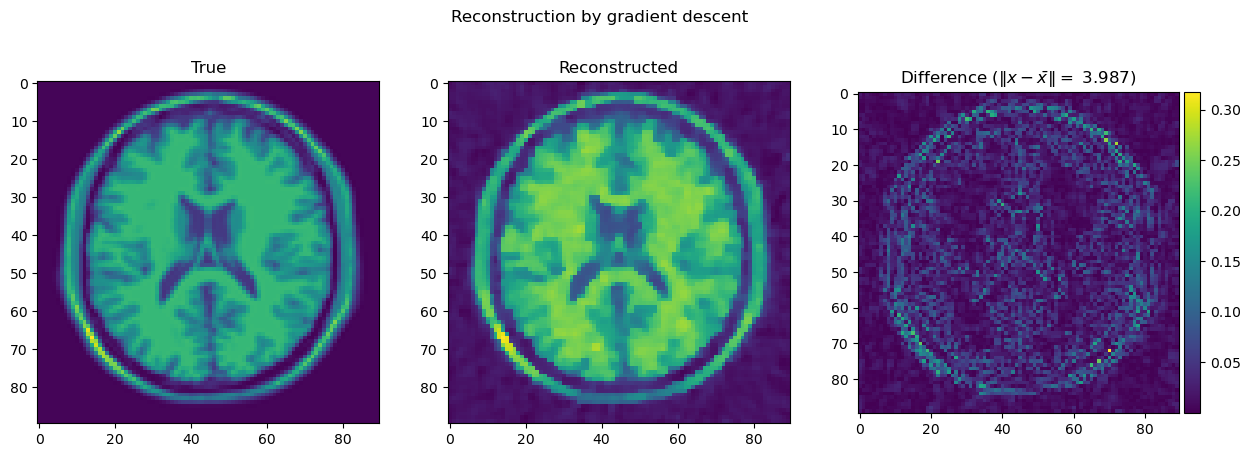

In [100]:
gd.run(x0)

plot_true_and_reconstructed(true_image, gd.reconstruction.reshape((N0, N1), order='F'), f"Reconstruction by {gd.name}")

In [101]:
save_run(gd, "gd")

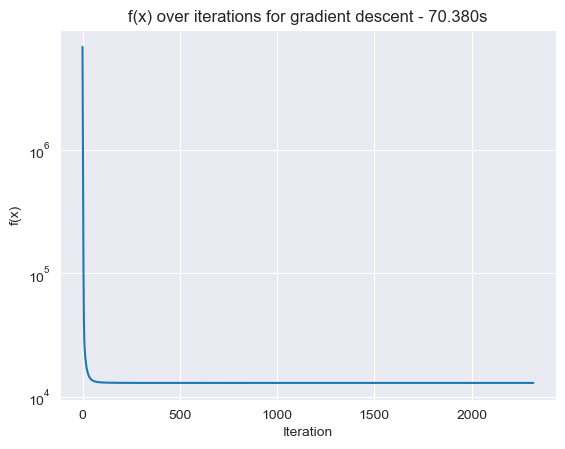

In [102]:
gd.plot_f_over_iterations()

### 3.2 - MM quadratic algorithm

#### Question 1.

#### <u>ANSWER 1</u>: coarse bound using second derivative

Using our previous computations, we find the following expression for the second derivatives of $f$ :
\begin{align*}
    \frac{\partial \nabla f(x)^{(i)}}{\partial x^{(j)}} & =(H^TH)^{(i,j)}+\lambda\sum_{n=1}^{2N}G^{(n,j)}G^{(n,i)}\frac{\delta}{\left(\delta^2+[Gx]^{(n)2}\right)^{3/2}}
\end{align*}
Which rewrites :
$$\boxed{\nabla^2 f(x)=H^TH+\lambda\delta\sum_{n=1}^{2N}\frac{G^{(n)T}G^{(n)}}{\left(\delta^2+\left([Gx]^{(n)}\right)^2\right)^{3/2}}}$$

We want to find a majorant $h$ of $f$ such that :
$$\forall x,z\in \mathbb{R}^N : h(x, z) = f(z) + \left\langle \nabla f(z) \big| x-z \right\rangle + \frac{1}{2} \left\langle A(x-z)\big| x-z \right\rangle$$
where $A(z)-\nabla^2f(x)$ is a positive semi-definite matrix. In fact $A(z)-\nabla^2f(x)$ being semi-definite positive is the only requirement for $h$ to be a majorant. From what we computed above, we would like to set $\boxed{A=H^TH+\lambda/\delta^2G^TG}$. To show that the positive semi-definite condition is met, let's write $A(z)=H^TH+\lambda G^TD(z)G$ where :
$$D_{old}(z)=\text{diag}\left(\frac{1}{\delta^2},\dots,\frac{1}{\delta^2}\right)$$
For $v\in\mathbb{R}^N$,
\begin{align*}
    v^T\left(A(z)-\nabla^2f(x)\right)v & =v^T\left(H^TH+\lambda G^TD_{old}(z)G-H^TH-\lambda\delta\sum_{n=1}^{2N}\frac{G^{(n)T}G^{(n)}}{\left(\delta^2+[Gx]^{(n)2}\right)^{3/2}}\right)v \\
                                       & =\lambda (Gv)^T\left(D_{old}(z)-\text{diag}_{1\leq i\leq 2N}\left(\frac{\delta}{\left(\delta^2+[Gx]^{(i)2}\right)^{3/2}}\right)\right)Gv
\end{align*}
Now we only need to check that $D_{old}(z)-\text{diag}_{1\leq i\leq 2N}\left(\frac{\delta}{\left(\delta^2+[Gx]^{(i)2}\right)^{3/2}}\right)$ is positive semi-definite. It's a diagonal matrix so we only need to check that its diagonal coefficients are positive. Let $n\in\left\{1,\dots,2N\right\}$. We have :
\begin{align*}
    \frac{1}{\delta^2}-\frac{\delta}{\left(\delta^2+[Gx]^{(n)2}\right)^{3/2}}
     & \geq \frac{1}{\delta^2}-\frac{\delta}{\left(\delta^2\right)^{3/2}} \\
     & \geq 0
\end{align*}

#### <u>ANSWER 2</u>: Finer bound using properties of even functions

Let us remark that:
- $\psi$ is differentiable on $\R^+$;
- $\psi(\sqrt{\cdot}) = x \mapsto \sqrt{1 + \frac{x}{\delta^2}}$ is concave on $\R^+$ as the composition of a concave function with an addine function;
- $\forall x \in \R^+$, $\dot{\psi}(x) \geq 0$ (which is obvious from the expression of this derivative);
- $\lim_{x \to 0^+} \frac{\dot{\psi}(x)}{x} = \lim_{x \to 0^+} \frac{1}{\delta \sqrt{\delta^2 + x^2}} = \frac{1}{\delta^2}$. Let us denote $\boxed{\omega: x \in \R \mapsto \frac{1}{\delta \sqrt{\delta^2 + x^2}}} $.

Therefore, a majorant $h$ for $\psi$ (which is even, and so is $\omega$) in $z \in \R$ is given by:
$$
    \forall x \in \R, \ h(x, z) = \psi(z) + \dot{\psi} (x-z) + \frac{1}{2} \omega(|z|)(x-z)^2.
$$

Now, let $z \in \R^N$ and $n \in \llbracket 1, 2 N \rrbracket$. A majorant $h_{r,n}$ of $\psi([G \cdot]^{(n)})$ is therefore:
\begin{align*}
    \forall x \in \R^N, \ h_{r,n}(x, z) & = \psi([G z]^{(n)}) + \dot{\psi}([G z]^{(n)}) ([G x]^{(n)}-[G z]^{(n)}) + \frac{1}{2} \omega(|[G z]^{(n)}|)([G x]^{(n)}-[G z]^{(n)})^2\\
    & = \psi([G z]^{(n)}) + \dot{\psi}([G z]^{(n)}) ([G (x - z)]^{(n)}) + \frac{1}{2} \omega([G z]^{(n)})([G (x-z)]^{(n)})^2.
\end{align*}
By summing, a majorant $h_r$ for $r$ in $z$ is thus:
\begin{align*}
    \forall x \in \R^N, \ h_r(x, z) &= \sum_{n=1}^{2 N} \left( \psi([G z]^{(n)}) + \dot{\psi}([G z]^{(n)}) ([G (x - z)]^{(n)}) + \frac{1}{2} \omega([G z]^{(n)})([G (x-z)]^{(n)})^2 \right)\\
     & = r(z) + (x-z)^T G^T \dot{\psi}(Gz) + \frac{1}{2} \sum_{n=0}^{2N} \omega([Gz]^{(n)})([G(x-z)]^{(n)})^2\\
     & = r(z) + (x-z)^T G^T \dot{\psi}(Gz) + \frac{1}{2} (x-z)^T G^T D(z) G (x-z)\\
     & = r(z) + <G^T \dot \psi (Gz), x-z> + \frac{1}{2} ||x-z||_{G^T D(z) G}^2
\end{align*}
where
$$\boxed{D(z)=\text{diag}\left(\omega\left(Gz\right)\right) \in \R^{2N \times 2N}}$$

On the other hand, it is clear that a majorant for $\| H \cdot - y \|^2$ is
$$ \forall x \in \R^N, \ h_H(x, z) = \frac{1}{2} ||Hz-y||^2 + <H^T (Hz - y), x-z> + ||x-z||_{H^T H}^2.$$

Overall, a majorant for $f$ in $z \in \R^N$ is:
$$ \forall x \in \R^N, \ \boxed{h  (x, z) = f(z) + <\nabla f(z), x-z> + ||x-z||^2_{H^T H + \lambda G^T D(z) G}}$$

This is a quadratic majorant with curvature:
$$ \boxed{A(z) = H^T H + \lambda G^T D(z) G} $$

In [103]:
def omega(x):
    return 1/(delta * np.sqrt(delta**2 + x**2))

def D(x):
    return sps.csc_matrix(sps.diags(omega(G @ x)))

def A(x):
    operator = lambda u: H.T @ (H @ u) + lambd * G.T @ (D(x) @ (G @ u))
    return sps.linalg.LinearOperator((N, N), matvec=operator, rmatvec=operator)

#### Question 2.

In [104]:
class MMQuadratic(Algorithm):
    def __init__(self, name, f, df, A, theta=1, lambd=lambd, delta=delta):
        super().__init__(name, f, df, lambd=lambd, delta=delta)
        self.A = A
        self.theta = theta

    def step(self, x) -> np.ndarray:
        grad = self.df(x)
        return x - self.theta * sps.linalg.bicg(self.A(x), grad)[0]

mmq = MMQuadratic("quadratic MM", f, grad_f, A, theta=1/2)

Converged after 125 iterations in 96.945 seconds.


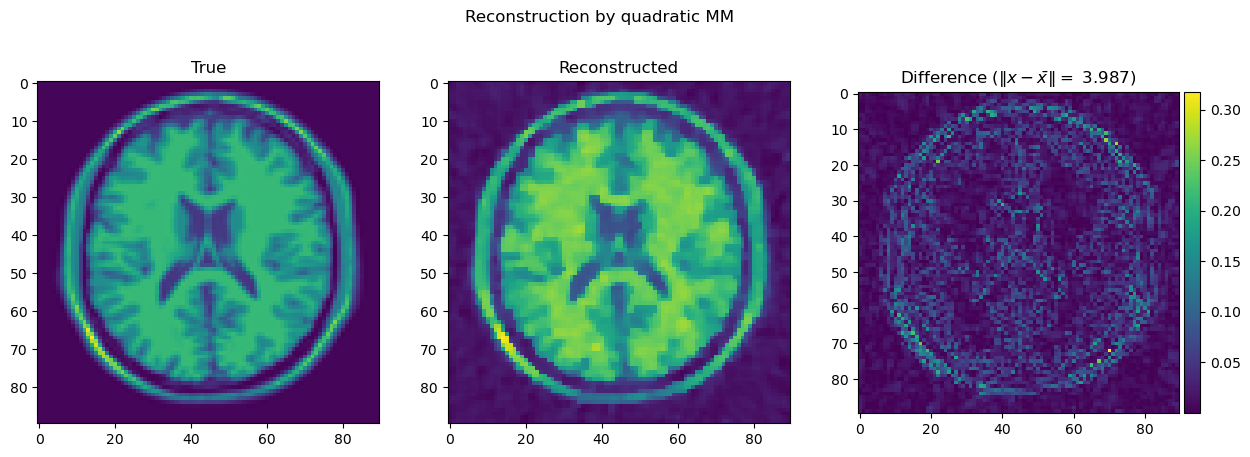

In [105]:
mmq.run(x0)

plot_true_and_reconstructed(true_image, mmq.reconstruction.reshape((N0, N1), order='F'), f"Reconstruction by {mmq.name}")

In [106]:
save_run(mmq, "mmq")

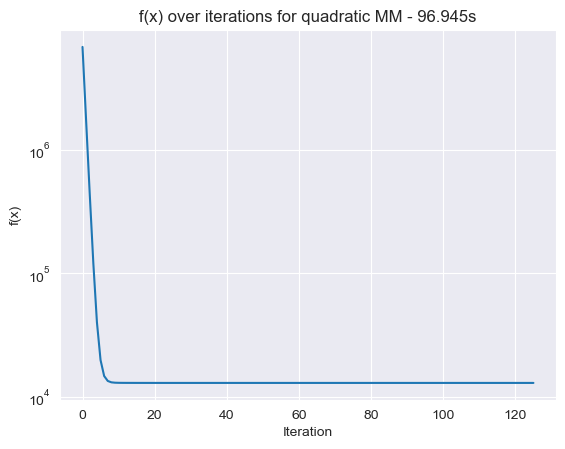

In [107]:
mmq.plot_f_over_iterations()

### 3.3 - 3MG algorithm

#### Question 1.

In [130]:
class M3G(Algorithm):
    def __init__(self, name, f, df, A, lambd=lambd, delta=delta):
        super().__init__(name, f, df, lambd=lambd, delta=delta)
        self.A = A
        self.M = np.zeros((len(x0), 2))

    def step(self, x) -> np.ndarray:
        grad = self.df(x)
        self.M[:, 0] = grad
        x_new = x - self.M @ sp.linalg.pinv(self.M.T @ (self.A(x) @ self.M)) @ (self.M.T @ grad)
        self.M[:, 1] = x_new - x
        return x_new

m3g = M3G("3MG", f, grad_f, A)

Converged after 137 iterations in 9.602 seconds.


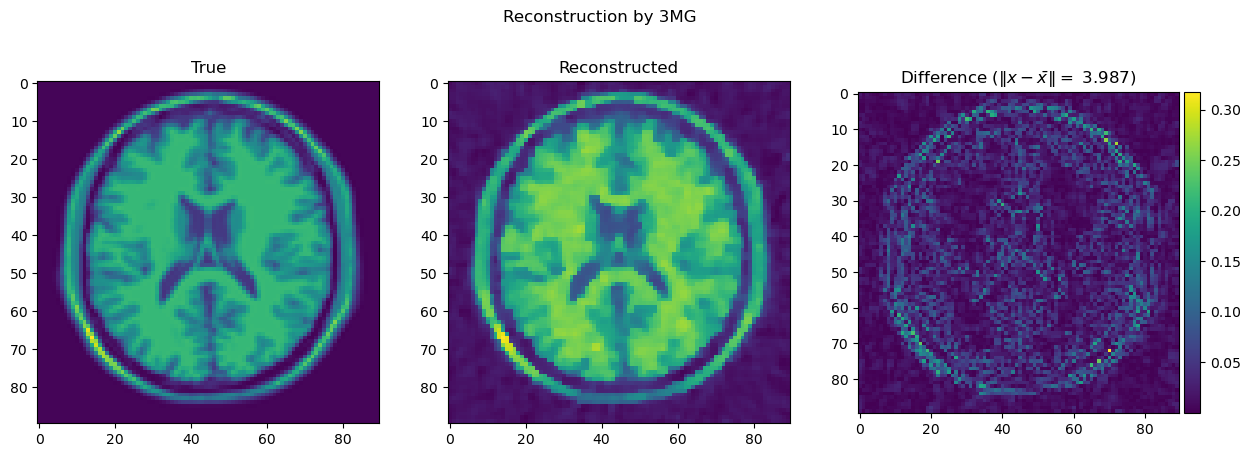

In [109]:
m3g.run(x0)

plot_true_and_reconstructed(true_image, m3g.reconstruction.reshape((N0, N1), order='F'), f"Reconstruction by {m3g.name}")

In [110]:
save_run(m3g, "m3g")

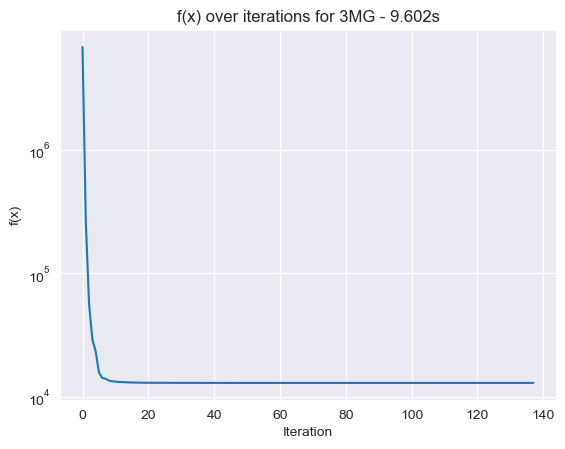

In [111]:
m3g.plot_f_over_iterations()

### 3.4 - Block-coordinate MM quadratic algorithm

#### Question 1.

In [112]:
def get_block_A(x, block=None):
    if block is None:
        block = np.arange(N)
    def operator(u):
        opH = H[:, block].T @ (H[:, block] @ u)
        opG = G[:, block].T @ (D(x) @ (G[:, block] @ u))
        return opH + lambd * opG
    return sps.linalg.LinearOperator(
        (len(block), len(block)), matvec=operator, rmatvec=operator
    )

#### Question 2.

In [113]:
class MMBlockCoordinate(Algorithm):
    def __init__(self, name, f, df, get_block_A, J, theta=1, lambd=lambd, delta=delta):
        super().__init__(name, f, df, lambd=lambd, delta=delta)
        self.get_block_A = get_block_A
        self.J = J
        self.theta = theta

    def get_block(self, Nj, j):
        return np.arange(Nj * (j - 1), Nj * j)

    def step(self, x) -> np.ndarray:
        Nj = N // self.J
        j = (self.iteration - 1) % self.J + 1
        block = self.get_block(Nj, j)
        block_A = self.get_block_A(x, block)
        block_df = self.df(x)[block]
        x_new = x.copy()
        x_new[block] -= self.theta * sps.linalg.bicg(block_A, block_df)[0]
        return x_new

mmbc = MMBlockCoordinate(f"block-coordinate MM (J={5})", f, grad_f, get_block_A, J=5, theta=1)

Converged after 346 iterations in 187.776 seconds.


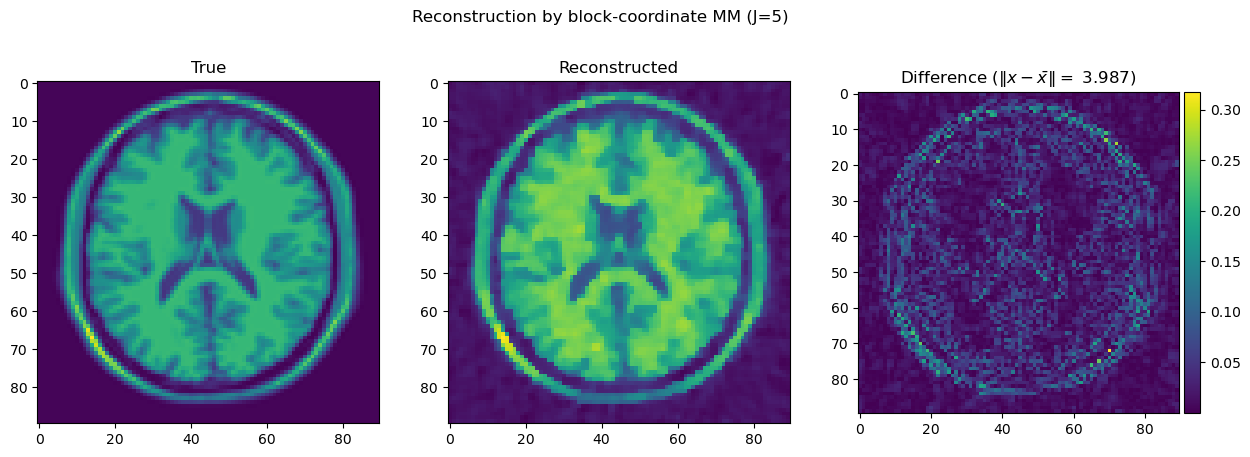

In [114]:
mmbc.run(x0)

plot_true_and_reconstructed(true_image, mmbc.reconstruction.reshape((N0, N1), order='F'), f"Reconstruction by {mmbc.name}")

In [115]:
save_run(mmbc, "mmbc")

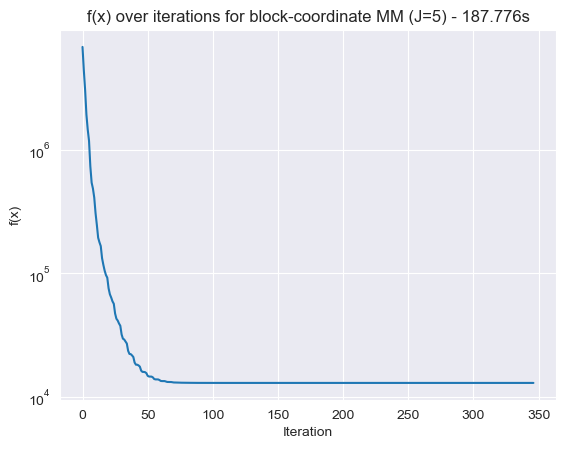

In [116]:
mmbc.plot_f_over_iterations()

Let's compare different block sizes. If $J=1$ we get the regular MM quadratic algorithm.

Converged after 127 iterations in 160.603 seconds.
Converged after 202 iterations in 164.820 seconds.
Converged after 346 iterations in 168.175 seconds.
Converged after 422 iterations in 186.207 seconds.
Converged after 601 iterations in 182.561 seconds.


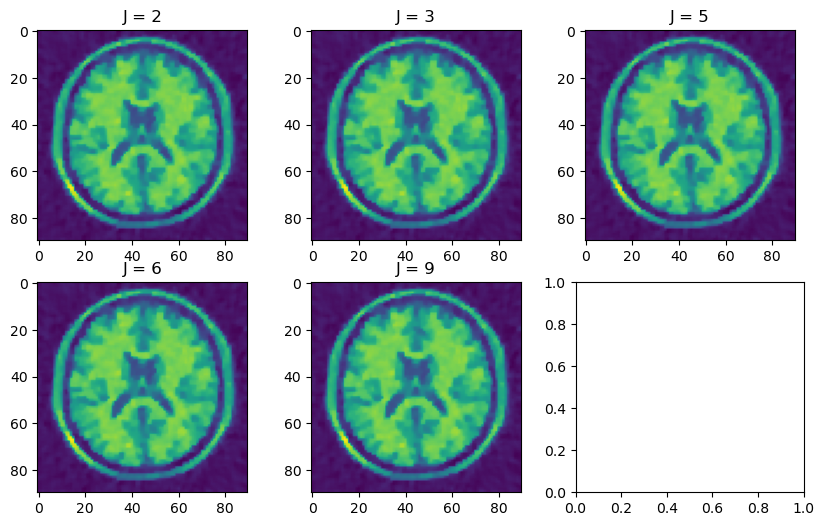

In [118]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

mmbcs = {}
for J, ax in zip([2, 3, 5, 6, 9], axs.flatten()):
    mmbcs[J] = MMBlockCoordinate(f"block-coordinate MM (J={J})", f, grad_f, get_block_A, J=J, theta=1)
    print("J = ", J, end="\r")
    mmbcs[J].run(x0)
    ax.imshow(mmbcs[J].reconstruction.reshape((N0, N1), order="F"))
    ax.set_title(f"J = {J}")
    save_run(mmbcs[J], f"mmbc_{J}")
plt.show()

### 3.5 - Parallel MM quadratic algorithm

#### Question 1.

For this question, we assume that in the handout, $\phi: x \in \R \mapsto \psi(|x|)$, that is $\phi = \psi$.

Let $x \in \R^N$.
Let us denote $B_H(x)$ the diagonal matrix with coefficients the $\mathcal{H}^T \mathbb{1}$
and $B_G(x)$ the diagonal matrix with coefficients the $\mathcal{G}^T  \left( \frac{\dot \psi (Gx)}{Gx} \right)$

Let $v \in \R^n$. Then,
$$
    v^T (B(x) - A(x)) v = \left( v^T B_H(x) v - v^T H^T H v \right) + \lambda \left( v^T B_G(x) v - v^T G^T D(x) G v \right)
$$

Let us work out the two terms one at a time.

<u>First term</u>

We have that
$$
v^T B_H v = \sum_{i=1}^{N} \mathcal{H}_i^T \mathbb{1} v_i^2
$$
where $\mathcal{H}_i^{(m)} = |H^{(m, i)}| \sum_{p=1}^N |H^{(m, p)}|$, that is
\begin{align*}
    v^T B_H v & = \sum_{i = 1}^{N} \left( \sum_{m=1}^M |H^{(m, i)}| \sum_{p=1}^N |H^{(m, p)}| \right) v_i^2\\
    & = \sum_{m=1}^{M} \sum_{i=1}^N \sum_{p=1}^N |H^{(m, p)}| |H^{(m, i)}|\, v_i^2
\end{align*}

Now,
\begin{align*}
    v^T H^T H v &= \| Hv \|^2\\
    & = \sum_{m=1}^{M} \left( \sum_{i=1}^N H^{(m, i)} v_i \right)^2\\
    & \leq \sum_{m=1}^{M} \left( \sum_{i=1}^N |H^{(m, i)}| |v_i| \right)^2
\end{align*}

Now, for all $m \in \llbracket 1, M \rrbracket$,
$$
    \left( \sum_{i=1}^N |H^{(m, i)}| |v_i| \right)^2 = \left( \sum_{i=1}^N \left( \underbrace{ \frac{|H^{(m, i)}|}{S}}_{\lambda_i}\left( S |v_i| \right)\right) \right)^2
$$
where $S = \sum_{p=1}^N |H^{(m, p)}|$.

Now, for all $i \in \llbracket 1, N \rrbracket$, $\lambda_i \in [0, 1]$ and $\sum_{i=1}^N \lambda_i = 1$, so by Jensen's inequality using the convexity of the square function,
$$
    \left( \sum_{i=1}^N |H^{(m, i)}| |v_i| \right)^2 = \sum_{i=1}^N \frac{|H^{(m, i)}|}{S} \left( S |v_i| \right)^2 = \sum_{i=1}^N |H^{(m, i)}|\, S\, v_i^2.
$$
So,
$$
    v^T H^T H v \leq \sum_{m=1}^{M} \sum_{i=1}^N \sum_{p=1}^N |H^{(m, p)}| |H^{(m, i)}|\, v_i^2 = v^T B_H v
$$

Therefore, $v^T B_H(x) v - v^T H^T H v \geq 0$.

<u>Second term</u>

Likewise,
$$
    v^T B_G(x) v = \sum_{n=1}^{2N} \sum_{i=1}^N \sum_{p=1}^N |G^{(n, p)}| |G^{(n, i)}|\, \omega([Gx]^{(n)})\, v_i^2
$$
and, now denoting $S = \sum_{p=1}^N |G^{(m, p)}|$ and reasoning as before:
$$
    v^T G^T D(x) G v = \sum_{n=1}^{2N} \omega(G(x)) \left( \sum_{i=1}^{N} G^{(n, i)} v_i \right)^2 \leq \sum_{n=1}^{2N} \omega(G(x)) \sum_{i=1}^N |G^{(n, i)}|\, S\, v_i^2 = v^T B_G(x) v.
$$
So, $v^T B_G(x) v - v^T G^T D(x) G v \geq 0$.

<u>Conclusion</u>

Therefore,
$$
    v^T (B(x) - A(x)) v \geq 0,
$$
so $\boxed{A(x) \preccurlyeq B(x)}$.

#### Question 2.

What we just proved shows that for all $z \in \R^N$, for all $x \in \R^N$,
$$
\|x-z\|_A^2 \leq \|x-z\|_B^2.
$$
Therefore,
$$
    h(x, z) = f(z)\, + <\nabla f(z), x-z> +\, ||x-z||^2_B
$$
is also a majorant of $f$ and we can use an MM quadratic algorithm using this new majorant.

In [119]:
def lmat(mat):
    row_sums = mat.sum(axis=1).reshape(mat.shape[0],1)
    return mat.multiply(row_sums)

def B(x):
    d = D(x).diagonal()
    b = np.asarray(np.sum(lmat(H).T, axis=1) + lambd * lmat(G).T @ d)[0]
    B = sps.diags(b).tocsc()
    operator = lambda u: B @ u
    return sps.linalg.LinearOperator(
        (N, N), matvec=operator, rmatvec=operator
    )

In [120]:
class ParallelMM(Algorithm):
    def __init__(self, name, f, df, B=B, lambd=lambd, delta=delta):
        super().__init__(name, f, df, lambd=lambd, delta=delta)
        self.B = B

    def step(self, x) -> np.ndarray:
        return x - sps.linalg.bicg(self.B(x), self.df(x))[0]


pmm = ParallelMM("parallel MM", f, grad_f, B)

Converged after 2220 iterations in 638.798 seconds.


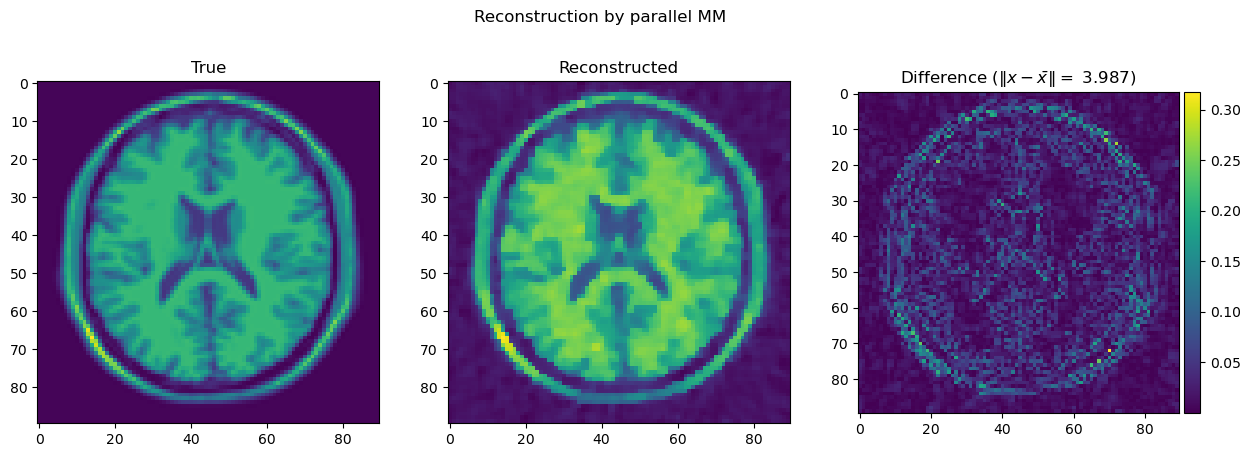

In [121]:
pmm.run(x0)

plot_true_and_reconstructed(true_image, pmm.reconstruction.reshape((N0, N1), order='F'), f"Reconstruction by {pmm.name}")

In [122]:
save_run(pmm, "pmm")

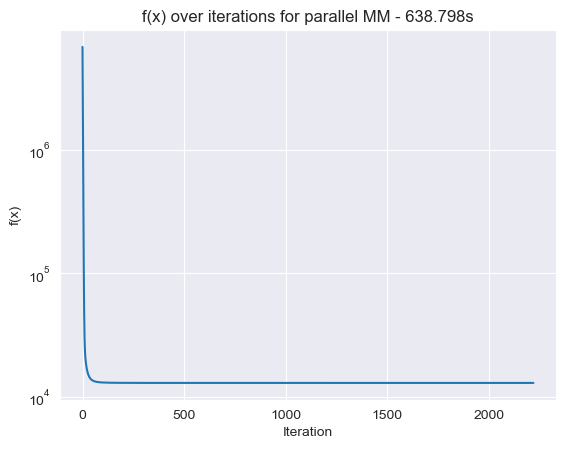

In [123]:
pmm.plot_f_over_iterations()

### 3.6 - Comparison of the methods

#### Question 1.

_Cf._ class ``Algorithm`` defined in Part 2, question 1.

#### Question 2.

***Remark: Running this question requires having run all previous cells***

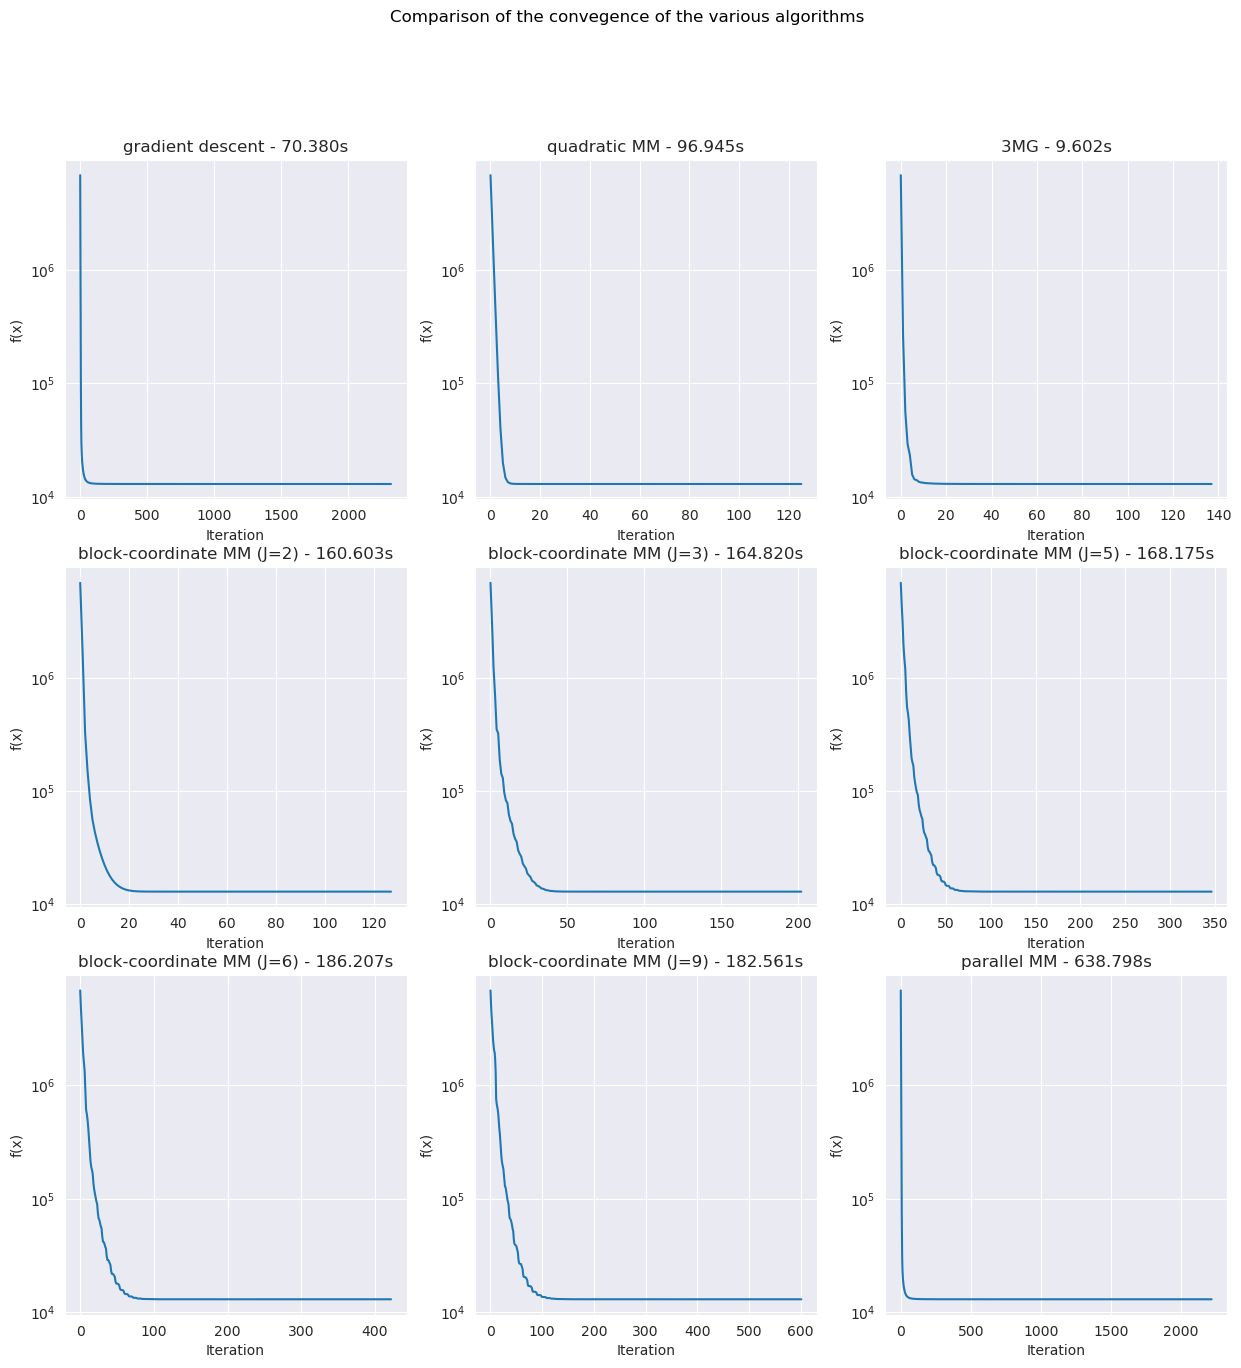

In [124]:
algos = [gd, mmq, m3g, *list(mmbcs.values()), pmm]
nrows, ncols = 1+(len(algos)-1)//3, 3
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
    for i in range(nrows*ncols):
        ax = axes[i//3, i%3]
        if i < len(algos):
            algo = algos[i]
            algo.plot_f_over_iterations(ax)
        else:
            ax.axis("off")
fig.suptitle("Comparison of the convegence of the various algorithms")
plt.show()

3MG seems to be the fastest method in wall time, although quadratic MM runs the smallest number of iterations. Also, gradient descent and the parallel MM algorithm quickly reach a reasonably good result, and further tuning of the step-size could improve convergence. Lastly, the parallel MM algorithm should be run on parallel threads for a fairer comparison, which is not done here.

#### Question 3.

Let us use the 3MG algorithm to optimize the SNR.

In [131]:
def SNR(x_true, reconstruction):
    return 10 * np.log10(np.sum(x_true**2) / np.sum((x_true-reconstruction)**2))

In [136]:
lambda_values = [0.01, 0.1, 1.0]
delta_values = [0.01, 0.1, 1.0]
best_lambda, best_delta, best_m3g, best_snr = None, None, None, -np.inf

snrs = {}
for lambd_idx, lambd in enumerate(lambda_values):
    snrs[lambd] = {}
    for delta_idx, delta in enumerate(delta_values):
        print(f"\n# lambda={lambd} - delta={delta}")
        
        psi = lambda x: np.sqrt(1 + (x/delta)**2)
        r = lambda x: np.sum(psi(G @ x))
        f = lambda x: 1/2 * np.linalg.norm(H @ x - y)**2 + lambd * r(x)
        def grad_f(x):
            prod = G @ x
            g = prod / delta / np.sqrt(delta**2 + prod**2)
            df = H.T @ (H @ x - y) + lambd * G.T @ g
            return df
        L = spectral_norm(H.T @ H) + lambd * spectral_norm(G.T @ G) / delta**2
        def omega(x):
            return 1/(delta * np.sqrt(delta**2 + x**2))
        def D(x):
            return sps.csc_matrix(sps.diags(omega(G @ x)))
        def A(x):
            operator = lambda u: H.T @ (H @ u) + lambd * G.T @ (D(x) @ (G @ u))
            return sps.linalg.LinearOperator((N, N), matvec=operator, rmatvec=operator)
        
        m3g = M3G("3MG", f, grad_f, A, lambd=lambd, delta=delta)
        m3g.run(x0)
        print(f"SNR = {SNR(true_image, m3g.reconstruction.reshape((N0, N1), order='F')):.3f}")
        snr = SNR(x, m3g.reconstruction)
        snrs[lambd][delta] = snr
        if snr > best_snr:
            best_lambda, best_delta, best_m3g, best_snr = lambd, delta, m3g, snr
        save_run(m3g, f"m3g_{lambd_idx}_{delta_idx}")
        print()

print("Best lambda:", best_lambda)
print("Best delta:", best_delta)
print("Best SNR:", best_snr)


# lambda=0.01 - delta=0.01
Converged after 324 iterations in 29.060 seconds.
SNR = 13.702


# lambda=0.01 - delta=0.1
Converged after 1473 iterations in 125.347 seconds.
SNR = 4.436


# lambda=0.01 - delta=1.0
Converged after 5480 iterations in 548.416 seconds.
SNR = -8.834


# lambda=0.1 - delta=0.01
Converged after 143 iterations in 12.962 seconds.
SNR = 18.277


# lambda=0.1 - delta=0.1
Converged after 310 iterations in 29.852 seconds.
SNR = 13.069


# lambda=0.1 - delta=1.0
Converged after 1654 iterations in 154.197 seconds.
SNR = 1.801


# lambda=1.0 - delta=0.01
Converged after 336 iterations in 28.805 seconds.
SNR = 11.579


# lambda=1.0 - delta=0.1
Converged after 107 iterations in 9.356 seconds.
SNR = 19.543


# lambda=1.0 - delta=1.0
Converged after 473 iterations in 45.482 seconds.
SNR = 9.195

Best lambda: 1.0
Best delta: 0.1
Best SNR: 19.542888846060738


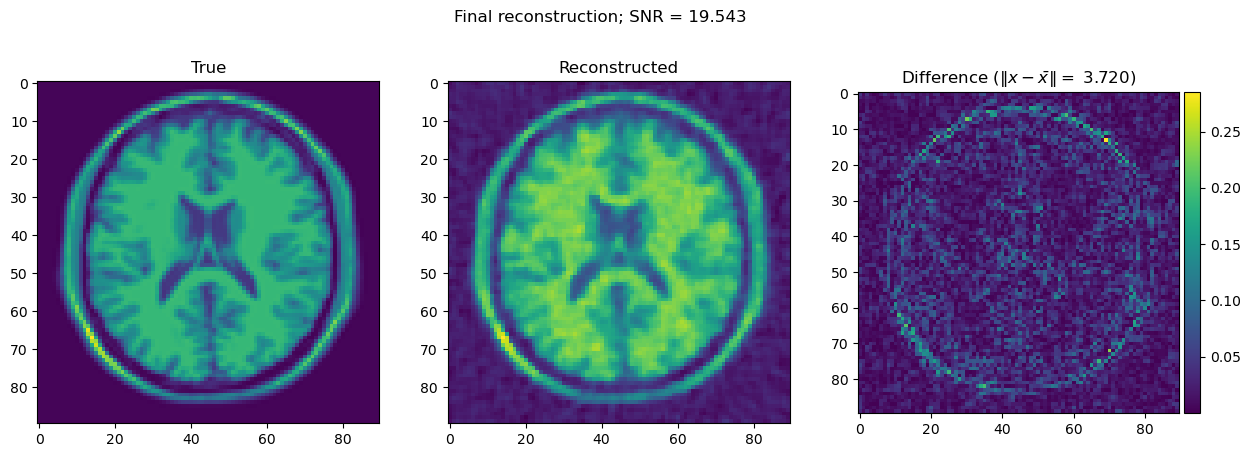

In [137]:
plot_true_and_reconstructed(true_image, best_m3g.reconstruction.reshape((N0, N1), order='F'), f"Final reconstruction; SNR = {best_snr:.3f}")

We get the best choice of parameters for $\lambda = 1.0$ and $\delta = 0.1$, giving a final SNR of $19.543$, and we do observe a smaller difference in $L^2$ norm compared to the previous run of the algorithm.